# AWS Sagemaker Project: Mushroom

Le but de notre projet est de determiner si un champignon est comestible ou pas en fonction de plusieurs attributs.

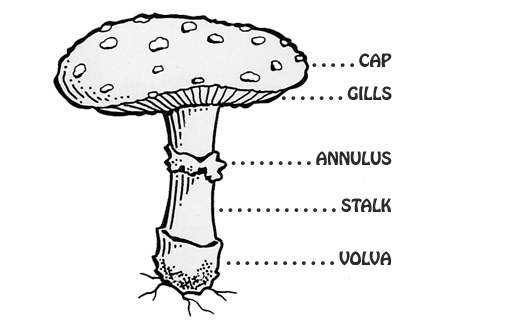

From the image, we can say that we have 5 main features of the mushroom:
- Cap: which is the top part of the mushroom from above, which takes the umberlla shape.
- Gill: which is the underside of the cap
- Ring: which is this little shape that surround the stem (stalk).
- Stalk: is what makes the mushroom standing, it's this vertical cylindrical.
- Veil: which is the bottom shape of the mushroom, that covers the bottom part of the mushroom.


Dans ce projet, nous allons tenter d'utilise le principe de cross validation ou validation croisée.
C'est une méthode d’estimation de fiabilité d’un modèle fondé sur une technique d’échantillonnage.

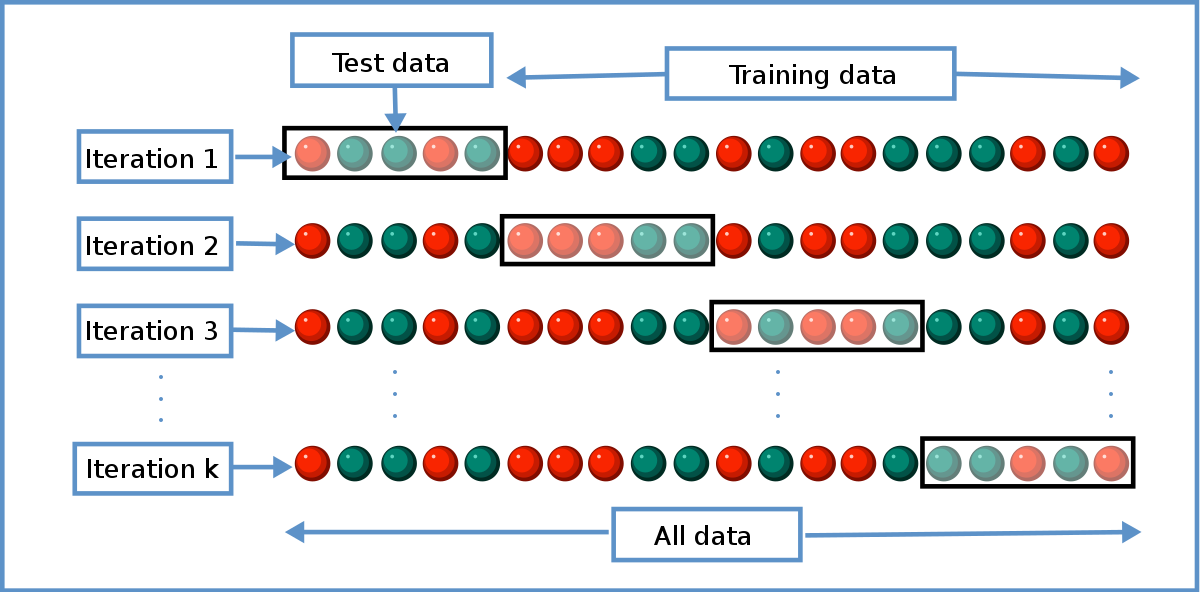

Comme on peut le voir sur l'image, l'idée est faire plusieurs entrainements du modèle en faisant glisser le jeu de test.
On peut utiliser cette méthode soit pour établir une performance plus précise d'un modèle en calculant la moyenne de tous les entrainements, soit pour tester différents paramètres pour trouver la configuration optimale avant de la soumettre au jeu de données de validation.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
import scipy.stats as ss
from io import StringIO, BytesIO
import boto3
import xgboost as xgb
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.estimator import Estimator

pd.set_option('display.max_columns', 23)

In [ ]:
#!python -m pip install xgboost seaborn==0.9.0

In [3]:
s3client = boto3.client(
    's3',
    region_name='us-west-1'
)

bucket = 'project-sagemaker-aws'
file_to_read = 'raw/mushrooms.csv' 

fileobj = s3client.get_object(Bucket=bucket, Key=file_to_read)
df = pd.read_csv(BytesIO(fileobj['Body'].read()))

In [ ]:
#df = pd.read_csv("mushrooms.csv")

## Data analysis

In [5]:
df.shape

(8124, 21)

In [30]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [31]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [32]:
for col in df.columns:
    print("\n---- %s ---" % col)
    print(df[col].value_counts(dropna=False))


---- class ---
e    4208
p    3916
Name: class, dtype: int64

---- cap-shape ---
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64

---- cap-surface ---
y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64

---- cap-color ---
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64

---- bruises ---
f    4748
t    3376
Name: bruises, dtype: int64

---- odor ---
n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64

---- gill-attachment ---
f    7914
a     210
Name: gill-attachment, dtype: int64

---- gill-spacing ---
c    6812
w    1312
Name: gill-spacing, dtype: int64

---- gill-size ---
b    5612
n    2512
Name: gill-size, dtype: int64

---- gill-color ---
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, d

In [4]:
df = df.drop(["veil-type", "stalk-root"], axis=1)

La dataset est constitué de plus de 8000 lignes et de 22 variables toute catégorielles,
C'est un problème de classification binaire où le but est de determiner si un champignon est comestible ou pas.

On remarque deux choses de la description des variables:
- la variable __veil-type__ n'a qu'une seule valeur, on peut donc la retirer.
- la variable __stalk-root__ peut avoir la valeur "?" qui correspond a priori à une valeur manquante.
Dans un premier temps, puisque l'on possède de nombreuses autres variables, on peut également la retirer.

Pour les autres on a entre 2 et 12 valeurs, certaines sont peu représentées (ex: cap-shape = c => 4 / 8124) mais jamais uniques, on ne les considère donc pas comme des anomalies.

Text(0.5, 1.0, 'Number of poisonous/edible mushrooms (e=edible, p=poisonous)')

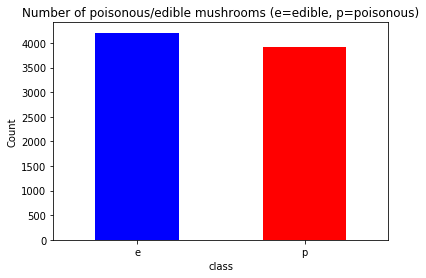

In [34]:
plt.figure()
pd.Series(df['class']).value_counts().sort_index().plot(kind='bar', color=('b','r'))
plt.ylabel("Count")
plt.xlabel("class")
plt.xticks(rotation=0)
plt.title('Number of poisonous/edible mushrooms (e=edible, p=poisonous)')

On vérifie ici que les données sont globalement bien réparties entre les 2 classes.

In [35]:
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(df):
    corr_mat = pd.DataFrame(np.eye(df.shape[1]), df.columns, df.columns)
    for col_A in df:
        for col_B in df.drop(col_A, axis=1):
            confusion_matrix = pd.crosstab(df[col_A], df[col_B])
            chi2 = ss.chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
            rcorr = r - ((r - 1) ** 2) / (n - 1)
            kcorr = k - ((k - 1) ** 2) / (n - 1)
            corr_mat[col_A][col_B] = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    return corr_mat

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text xticklabel objects>)

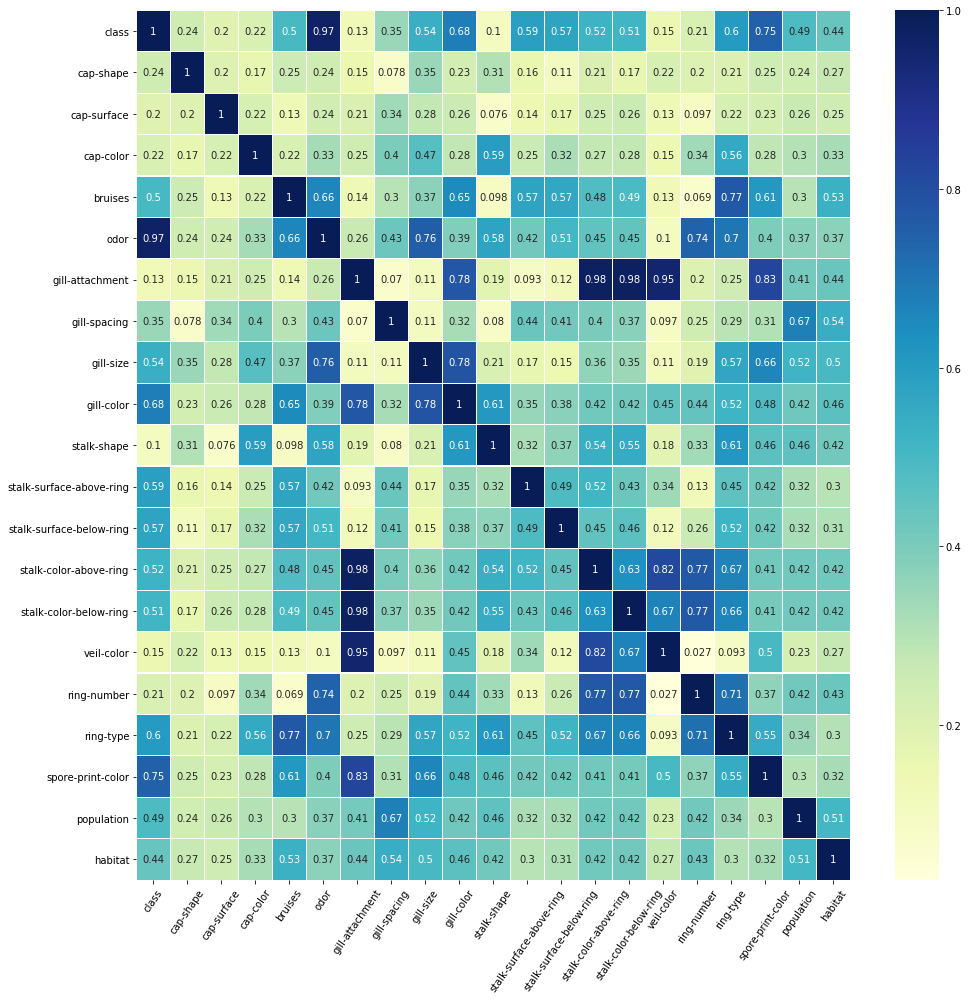

In [36]:
plt.figure(figsize=(16, 16))
sns.heatmap(cramers_v(df), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=55)

On recherche les corrélations entre les différentes variables.

On ne peut pas utiliser la matrice de corrélations classique (utilisant le test de Pearson) puisqu'il s'agit ici de variables catégorielles/nominales.

On peut cependant calculer l'indice de Cramér pour déterminer l'association entre deux variables. L'interprétation reste là même que pour une matrice de corrélation sauf qu'ici les valeurs sont forcément positives.

---

On remarque alors que la __class__ (variable à prédire) est fortement associée à la variable __odor__ (97%): c'est donc une feature qu'il va falloir garder et surveiller.

De plus la variable __gill-attachment__ est associée à __veil-color__, __stalk-color-above-ring__ et __stalk-color-below-ring__.
Si besoin, on pourrait retirer ces trois dernières variables puisque les données sont déjà fortement représentées par la première.


### Analyse du domaine d'application

Le principal objectif ici étant de différencier un champignon comestible d'un champignon vénéneux à partir de ses caractéristiques.
On peut imaginer par exemple une application mobile que des randonneurs utiliseraient lors de passages en forets pour s'assurer que les champignons ceuillis soient bien comestibles.

## Data scaling & transformation
We can use one hot encoding or label encoding
and normalization or standardization

In [37]:
X = df.drop(['class'], axis=1)
Y = df['class']

In [38]:
# Get dummy variables for each column in X.
X_dummy = pd.get_dummies(X, drop_first=True)
print('Number of columns generated from dummy variables =', len(X_dummy.columns.values),'Columns')

Number of columns generated from dummy variables = 91 Columns


In [39]:
# Example using standardization /!\ Needed for PCA but not necessary for xgboost
X_std = StandardScaler().fit_transform(X_dummy)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [40]:
# Update the dataframe with one hot encoding and normalization
# Explain why the other transformations are less usefull or unnecessary
# Ex for scaling: MinMaxScaler, Normalizer, QuantileTransformer

On utilise le One Hot Encoding plutôt que le Label Encoding puisque ce dernier est moins précis pour les algorithmes liés aux arbres décisionnels (Random Forest, XGBoost, etc.)

De même on utilise la standardisation pour obtenir un dataset centré et réduit.
Cela nous permet d'utiliser à la fois l'ACP (prérequis) et d'économiser du temps de calcul ainsi que de prévenir certains effets de bords ou indésirables que peuvent avoir des algorithmes sur des variables d'échelles différentes.

On aurait aussi pu utiliser un MinMaxScaler, un Normalizer ou un QuantileTransformer pour transformer la donnée.
Cependant le premier ne produit pas une donnée centrée et réduite et les deux autres sont des transformations non-linéaires qui peuvent modifier la structure intrinsèque de la donnée si on ne les utilisent pas dans les bonnes conditions. Nous avons donc opté pour la standardisation.

## Data Visualization

Using dimensionality reduction

In [41]:
X_pca = PCA(n_components=2).fit_transform(X_std)

print('Original Number of features =',  X_dummy.shape[1] ,'columns')
print('Reduced Number of features =', X_pca.shape[1], 'columns')

Original Number of features = 91 columns
Reduced Number of features = 2 columns


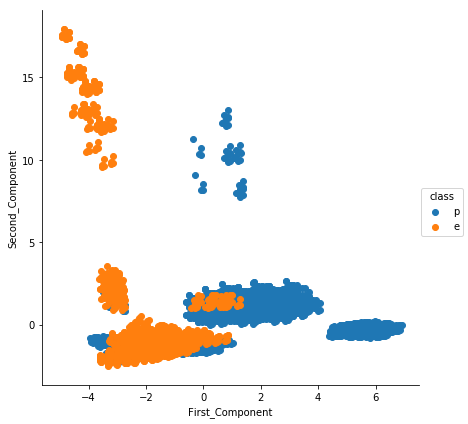

In [42]:
# Attach the label for each 2-d data point
X_pca = np.vstack((X_pca.T, Y)).T

df_pca = pd.DataFrame(X_pca, columns=['First_Component',
                                      'Second_Component',
                                      'class'])
sns.FacetGrid(data=df_pca, hue='class', size=6)\
   .map(plt.scatter, 'First_Component', 'Second_Component')\
   .add_legend()

Text(0, 0.5, 'Cumulative Explained Variance')

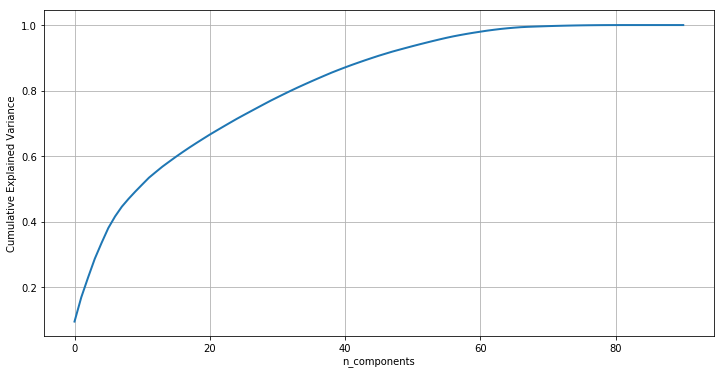

In [43]:
# I'll create a CDF for number of features, to answer that question
pca = PCA(n_components=91)
X_pca = pca.fit_transform(X_std)

percent_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

cum_var_explained = np.cumsum(percent_var_explained)

# Plot the PCA Spectrum
plt.figure(1, figsize=(12, 6))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')

In [44]:
# Create a PCA that will retain 97 of the variance
pca = PCA(n_components=0.97, whiten=True)

# Conduct PCA
X_pca = pca.fit_transform(X_std)

# Show the result
print('Original number of features:', X_dummy.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 91
Reduced number of features: 59


In [45]:
tsne = TSNE(n_components=2, random_state=0)

X_tsne = tsne.fit_transform(X_std)

In [ ]:
# Create the dataframe to plot
X_tsne_data = np.vstack((X_tsne.T, Y)).T
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2', 'class'])

# Plot the 2 components from t-SNE
sns.FacetGrid(df_tsne, hue='class', height=6)\
   .map(plt.scatter, 'Dim1', 'Dim2')\
   .add_legend()

## Dataset split into train test and validation sets

In [66]:
df = pd.concat([(Y == "e").astype(int), pd.DataFrame(X_std, columns=X_dummy.columns)], axis=1)

In [28]:
temp_set, valid_set = train_test_split(df, test_size=0.2)
train_set, test_set = train_test_split(temp_set, test_size=0.25)

In [29]:
print('Training dataset: {}'.format(train_set.shape))
print('Validation dataset: {}'.format(valid_set.shape))
print('Test dataset: {}'.format(test_set.shape))

Training dataset: (4874, 92)
Validation dataset: (1625, 92)
Test dataset: (1625, 92)


## Stockage des dataset dans un compartiment S3

In [31]:
data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
for data_partition_name, data_partition in data_partitions:
    print('{}: {}'.format(data_partition_name, data_partition.shape))

    np.savetxt('data.csv', data_partition, delimiter=',')
    key = "{}/examples".format(data_partition_name)
    url = 's3://{}/{}'.format(bucket, key)
    s3client.upload_file('data.csv', bucket, key)
    print('Done writing to {}'.format(url))

train: (4874, 92)
Done writing to s3://project-sagemaker-aws/train/examples
validation: (1625, 92)
Done writing to s3://project-sagemaker-aws/validation/examples
test: (1625, 92)
Done writing to s3://project-sagemaker-aws/test/examples


## Création et entrainement du modèle

In [8]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

	get_image_uri(region, 'xgboost', '0.90-1').


In [14]:
train_data = 's3://{}/{}'.format(bucket, 'train')

validation_data = 's3://{}/{}'.format(bucket, 'validation')

s3_output_location = 's3://{}/{}'.format(bucket, 'xgboost_model_sdk')

In [9]:
role = get_execution_role()

In [37]:
xgb_model = Estimator(container,
                     role, 
                     train_instance_count=1, 
                     train_instance_type='ml.m4.xlarge',
                     train_volume_size = 5,
                     output_path=s3_output_location,
                     sagemaker_session=sagemaker.Session())

In [38]:
xgb_model.set_hyperparameters(objective = "binary:logistic",
                              num_round = 20,
                              verbosity = 2)

In [39]:
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [40]:
xgb_model.fit(inputs=data_channels, logs=True)

2020-02-04 08:13:00 Starting - Starting the training job...
2020-02-04 08:13:01 Starting - Launching requested ML instances......
2020-02-04 08:14:26 Starting - Preparing the instances for training......
2020-02-04 08:15:22 Downloading - Downloading input data...
2020-02-04 08:16:01 Training - Training image download completed. Training in progress..Arguments: train
[2020-02-04:08:16:02:INFO] Running standalone xgboost training.
[2020-02-04:08:16:02:INFO] File size need to be processed in the node: 14.72mb. Available memory size in the node: 8523.58mb
[2020-02-04:08:16:02:INFO] Determined delimiter of CSV input is ','
[08:16:02] S3DistributionType set as FullyReplicated
[08:16:02] 4874x91 matrix with 443534 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-02-04:08:16:02:INFO] Determined delimiter of CSV input is ','
[08:16:02] S3DistributionType set as FullyReplicated
[08:16:02] 1625x91 matrix with 147875 entries loaded from /opt/ml/input/data/va

## Check feature importance in the model

In [41]:
# Get the feature importance of the model
import tarfile
import pickle as pkl

# download the model artifact from AWS S3
!aws s3 cp s3://project-sagemaker-aws/xgboost_model_sdk/xgboost-2020-02-04-08-12-59-923/output/model.tar.gz .

#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))

download: s3://project-sagemaker-aws/xgboost_model_sdk/xgboost-2020-02-04-08-12-59-923/output/model.tar.gz to ./model.tar.gz


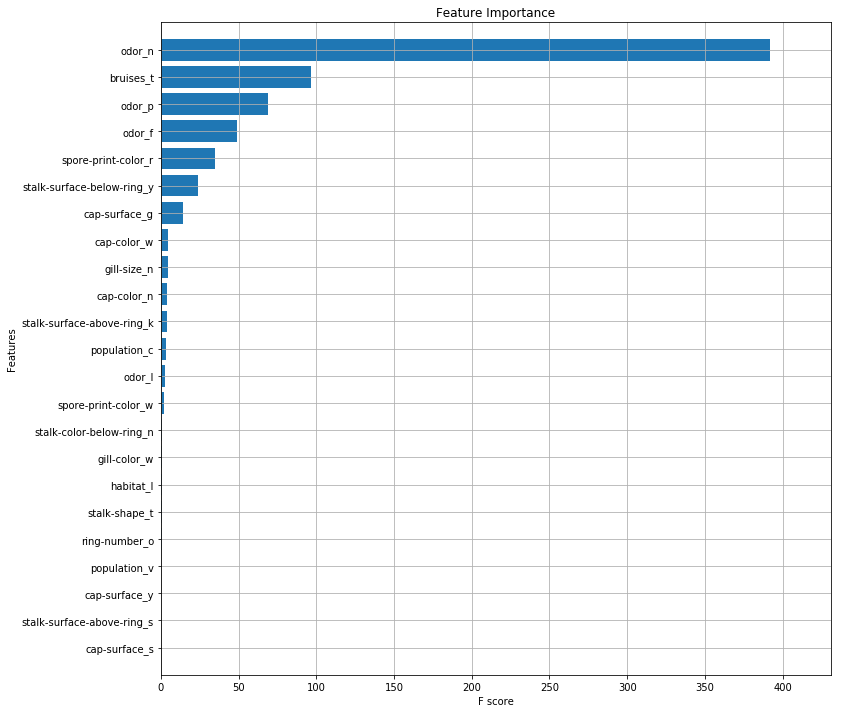

In [43]:
map_names = dict(zip(model.feature_names, train_set.drop(['class'], axis=1).columns))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

## Make predictions and evaluate the model

In [77]:
## Deploy trained XGBoost model endpoint to perform predictions
xgb_predictor = xgb_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

## Function to chunk down test set into smaller increments

def predict(data, model):
    split_array = np.array_split(data, data.shape[0])
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

## Generate predictions on the test set for the difference models

predictions = predict(test_set.drop(['class'], axis=1).values, xgb_predictor)

Text(0.5, 15.0, 'Predicted label')

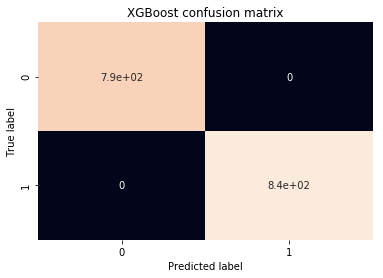

In [81]:
y_pred = (predictions > 0.5).astype(int)
cfm = confusion_matrix(test_set['class'], y_pred)

sns.heatmap(cfm, annot=True, cbar=False)
plt.title('XGBoost confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

AUC is 1.0


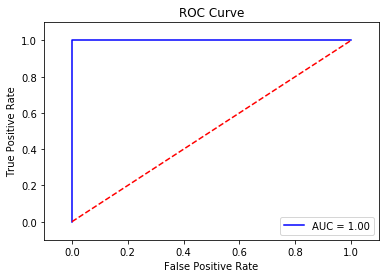

In [83]:
auc = round(roc_auc_score(test_set['class'], y_pred), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = roc_curve(test_set['class'], y_pred)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Sagemaker needs a validation set to select the best model from several trainings
# Sometimes for a model or for example in a hyperparameter tuning job
# Thus we need a third set to test the performance of the model